### Plot a summary for the full, morning and evening limb transmission spectra

In [1]:
import warnings
from pathlib import Path

import iris
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
from tqdm.notebook import tqdm as tqdm

In [2]:
from aeolus.plot import add_custom_legend

In [3]:
from util_commons import ABSORBERS, PLANETS

In [4]:
warnings.filterwarnings("ignore", module="iris")
warnings.filterwarnings("ignore", module="aeolus")
rcParams["mathtext.default"] = "regular"

In [5]:
# Project
planet = "wasp96b"
path_to_project = Path.home() / "projects" / planet
# Absorbers
absrbrs = [
    "all",
    # "h2_h2_cia",
    # "h2_he_cia",
    # "li",
    # "na",
    # "k",
    # "rb",
    # "cs",
    # "ch4",
    # "co",
    # "co2",
    # "h2o",
    # "hcn",
    # "nh3",
]

In [6]:
# Load combined resolution UM transmission spectra
path_to_combores = Path.cwd() / "processed" / "transpec_combores"
combores = {}
for exp in ["equilibrium", "kinetics"]:
    combores[exp] = {}
    for mdh in ["mdh0", "mdh1"]:
        combores[exp][mdh] = {}
        for absrbr in tqdm(absrbrs):
            combores[exp][mdh][absrbr] = {}
            for limb in ["full", "morning", "evening"]:
                combores[exp][mdh][absrbr][limb] = {}
                fname_combores = (
                    f"um_{planet}_{exp[0:3]}_{mdh}_transpec_combores_{absrbr}_{limb}.nc"
                )
                cb_combores = iris.load_cube(path_to_combores / fname_combores)
                combores[exp][mdh][absrbr][limb] = cb_combores

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
# Calculate UM full limb differences between kinetics and equilibrium at the same metallicity
kin_mdh0_m_equ_mdh0 = (
    combores["kinetics"]["mdh0"]["all"]["full"] - combores["equilibrium"]["mdh0"]["all"]["full"]
)
kin_mdh1_m_equ_mdh1 = (
    combores["kinetics"]["mdh1"]["all"]["full"] - combores["equilibrium"]["mdh1"]["all"]["full"]
)

In [8]:
def plt_transpec_summary_full_mor_eve(absrbrs, wl_range):
    """Plot combined low and high resolution UM transmission spectra: full, morning and evening limbs."""
    plt_absrbrs = absrbrs
    if wl_range == "02_30":
        xmin, xmax = 0.2, 30
        xticks = np.concatenate(
            [
                np.array([0.2, 0.4, 0.6, 0.8]),
                np.array([1, 1.4]),
                np.array([2, 3, 4, 6, 8, 10, 15, 20, 30]),
            ]
        )
    if wl_range == "02_12":
        xmin, xmax = 0.2, 12
        xticks = np.concatenate(
            [
                np.array([0.2, 0.4, 0.6, 0.8]),
                np.array([1, 1.4]),
                np.array([2, 3, 4, 6, 8, 10, 12]),
            ]
        )
    fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(10, 12), constrained_layout=True)
    for exp, exp_ls in zip(["equilibrium", "kinetics"], ["dashed", "solid"]):
        for mdh, mdh_lw in zip(["mdh0", "mdh1"], [2, 1]):
            for absrbr in plt_absrbrs:
                plt_full_combores = combores[exp][mdh][absrbr]["full"]
                plt_mor_combores = combores[exp][mdh][absrbr]["morning"]
                plt_eve_combores = combores[exp][mdh][absrbr]["evening"]
                plt_x_combores = (
                    combores[exp][mdh][absrbr]["full"].coord("spectral_band_centres").points * 1e6
                )  # micrometers
                plt_eve_m_mor = plt_eve_combores - plt_mor_combores
                axs[0].plot(
                    plt_x_combores,
                    plt_full_combores.data,
                    linestyle=exp_ls,
                    linewidth=mdh_lw,
                    color=ABSORBERS[absrbr]["color"],
                )
                axs[1].plot(
                    plt_x_combores,
                    plt_mor_combores.data,
                    linestyle=exp_ls,
                    linewidth=mdh_lw,
                    color="C0",
                )
                axs[1].plot(
                    plt_x_combores,
                    plt_eve_combores.data,
                    linestyle=exp_ls,
                    linewidth=mdh_lw,
                    color="C1",
                )
                axs[3].plot(
                    plt_x_combores,
                    plt_eve_m_mor.data,
                    linestyle=exp_ls,
                    linewidth=mdh_lw,
                    color="grey",
                )
    axs[3].axhline(0, ls="dotted", lw=0.75, color="grey")
    # UM full limb differences
    axs[2].plot(
        plt_x_combores,
        kin_mdh0_m_equ_mdh0.data,
        linestyle="dotted",
        linewidth=2,
        color="blueviolet",
    )
    axs[2].plot(
        plt_x_combores,
        kin_mdh1_m_equ_mdh1.data,
        linestyle="dotted",
        linewidth=1,
        color="blueviolet",
    )
    axs[2].axhline(0, ls="dotted", lw=0.75, color="grey")
    fig.suptitle(f'{PLANETS[planet]["tex"]} simulated transmission spectra')
    axs[0].set_title("(a)", loc="left")
    axs[1].set_title("(b)", loc="left")
    axs[2].set_title("(c)", loc="left")
    axs[3].set_title("(d)", loc="left")
    axs[0].set_title("Full limb", loc="center")
    axs[1].set_title("Morning and evening limb", loc="center")
    axs[2].set_title("Full limb difference", loc="center")
    axs[3].set_title("Evening minus morning limb difference", loc="center")
    axs[3].set_xlabel("Wavelength [$\mu$m]")
    axs[0].set_ylabel("$(R_p/R_s)^2$ [ppm]")
    axs[1].set_ylabel("$(R_p/R_s)^2$ [ppm]")
    axs[2].set_ylabel("$\Delta(R_p/R_s)^2$ [ppm]")
    axs[3].set_ylabel("$\Delta(R_p/R_s)^2$ [ppm]")
    axs[0].set_ylim(14800, 16700)
    axs[1].set_ylim(14800, 16700)
    axs[2].set_ylim(-200, 500)
    axs[3].set_ylim(-200, 500)
    for ax in axs.flatten():
        ax.set_xscale("log")
        ax.set_xlim(xmin, xmax)
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticks)
    # Legends
    exp_dict = {
        "Equilibrium": {"color": "k", "ls": "dashed", "lw": 1},
        "Kinetics": {"color": "k", "ls": "solid", "lw": 1},
    }
    mdh_dict = {
        "[M/H]=0": {"color": "k", "ls": "solid", "lw": 2},
        "[M/H]=1": {"color": "k", "ls": "solid", "lw": 1},
    }
    limb_dict = {
        "Morning": {"color": "C0", "ls": "solid", "lw": 1},
        "Evening": {"color": "C1", "ls": "solid", "lw": 1},
    }
    full_diff_dict = {
        "Kin [M/H]=0 - Equ [M/H]=0": {"color": "blueviolet", "ls": "dotted", "lw": 2},
        "Kin [M/H]=1 - Equ [M/H]=1": {"color": "blueviolet", "ls": "dotted", "lw": 1},
    }
    limb_diff_dict = {
        "Equ [M/H]=0": {"color": "grey", "ls": "dashed", "lw": 2},
        "Kin [M/H]=0": {"color": "grey", "ls": "solid", "lw": 2},
        "Equ [M/H]=1": {"color": "grey", "ls": "dashed", "lw": 1},
        "Kin [M/H]=1": {"color": "grey", "ls": "solid", "lw": 1},
    }
    add_custom_legend(
        axs[0],
        exp_dict,
        frameon=False,
        title="Chemical scheme:",
        alignment="left",
        loc="upper left",
    )
    add_custom_legend(
        axs[0],
        mdh_dict,
        frameon=False,
        title="Metallicity:",
        alignment="left",
        loc="lower left",
    )
    add_custom_legend(axs[1], limb_dict, frameon=False, alignment="left", loc="upper left")
    add_custom_legend(axs[2], full_diff_dict, frameon=False, alignment="left", loc="upper left")
    add_custom_legend(
        axs[3], limb_diff_dict, frameon=False, alignment="left", loc="lower left", ncol=2
    )
    axs[0].legend(frameon=False)
    axs[1].legend(frameon=False)
    axs[2].legend(frameon=False)
    axs[3].legend(frameon=False)
    figname_png = f"{planet}_transpec_wl{wl_range}_combores_full_mor_eve.png"
    figname_pdf = f"{planet}_transpec_wl{wl_range}_combores_full_mor_eve.pdf"
    fig.savefig(path_to_project / "transmission" / figname_png)
    fig.savefig(path_to_project / "transmission" / figname_pdf, format="pdf", bbox_inches="tight")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


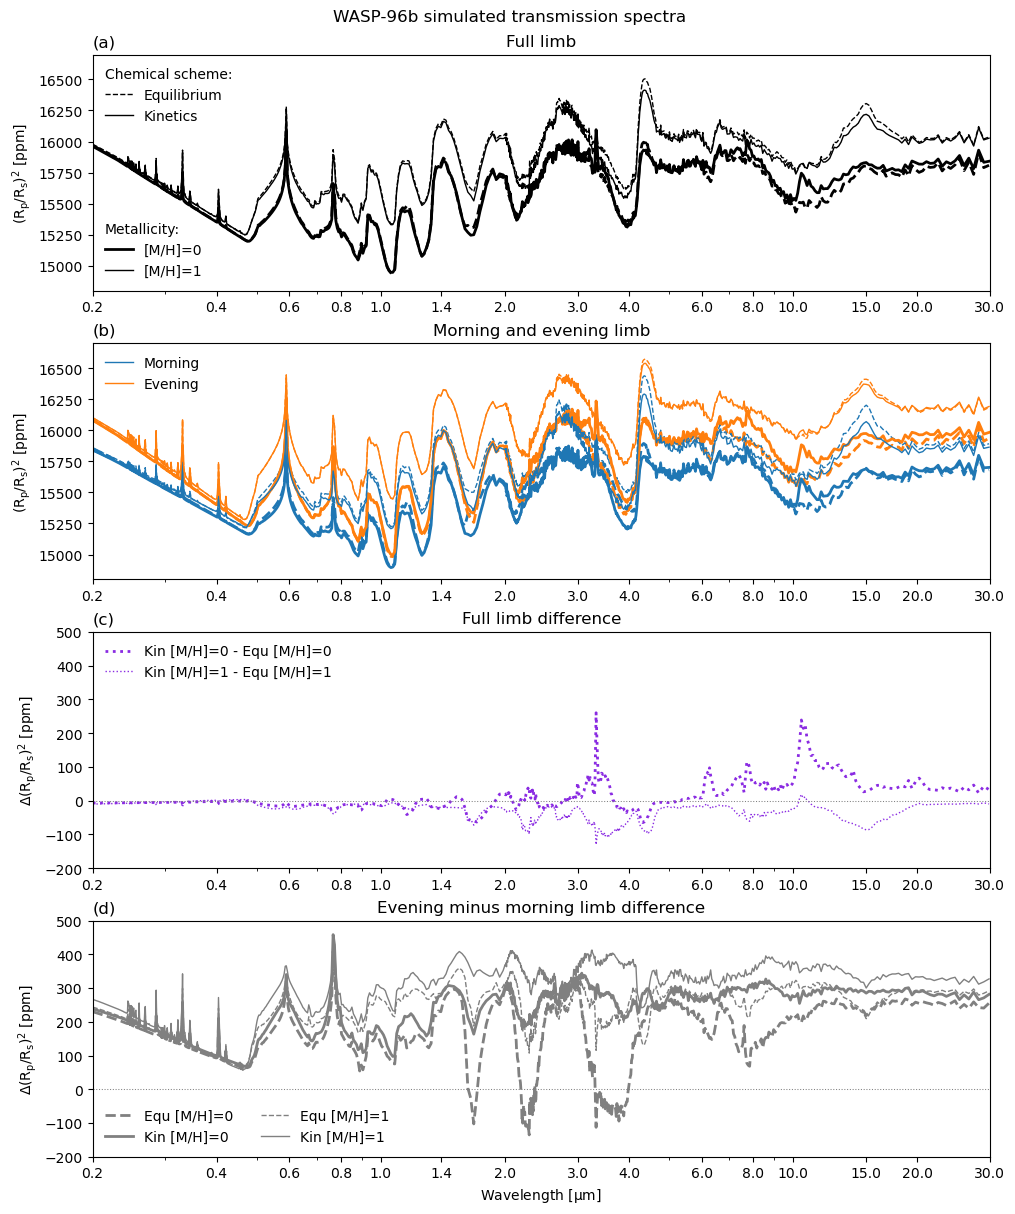

In [9]:
plt_transpec_summary_full_mor_eve(absrbrs, "02_30")

In [10]:
# plt_transpec_summary_full_mor_eve(absrbrs, "02_12")

In [11]:
def plt_transpec_summary_mor_eve(absrbrs, wl_range):
    """Plot combined low and high resolution UM transmission spectra: morning and evening limbs."""
    plt_absrbrs = absrbrs
    if wl_range == "02_30":
        xmin, xmax = 0.2, 30
        xticks = np.concatenate(
            [
                np.array([0.2, 0.4, 0.6, 0.8]),
                np.array([1, 1.4]),
                np.array([2, 3, 4, 6, 8, 10, 15, 20, 30]),
            ]
        )
    if wl_range == "02_12":
        xmin, xmax = 0.2, 12
        xticks = np.concatenate(
            [
                np.array([0.2, 0.4, 0.6, 0.8]),
                np.array([1, 1.4]),
                np.array([2, 3, 4, 6, 8, 10, 12]),
            ]
        )
    fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(10, 12), constrained_layout=True)
    for ax, exp, exp_ls, mdh, mdh_lw in zip(
        axs.flatten(),
        ["equilibrium", "equilibrium", "kinetics", "kinetics"],
        ["dashed", "dashed", "solid", "solid"],
        ["mdh0", "mdh1", "mdh0", "mdh1"],
        [1, 1, 1, 1],
    ):
        ax.set_title(f"{exp.capitalize()} [M/H]={mdh[-1]}", loc="center")
        for absrbr in plt_absrbrs:
            plt_full_combores = combores[exp][mdh][absrbr]["full"]
            plt_mor_combores = combores[exp][mdh][absrbr]["morning"]
            plt_eve_combores = combores[exp][mdh][absrbr]["evening"]
            plt_x_combores = (
                combores[exp][mdh][absrbr]["full"].coord("spectral_band_centres").points * 1e6
            )  # micrometers
            ax.plot(
                plt_x_combores,
                plt_mor_combores.data,
                linestyle=exp_ls,
                linewidth=mdh_lw,
                color="C0",
            )
            ax.plot(
                plt_x_combores,
                plt_eve_combores.data,
                linestyle=exp_ls,
                linewidth=mdh_lw,
                color="C1",
            )
    fig.suptitle(f'{PLANETS[planet]["tex"]} simulated morning and evening transmission spectra')
    axs[0].set_title("(a)", loc="left")
    axs[1].set_title("(b)", loc="left")
    axs[2].set_title("(c)", loc="left")
    axs[3].set_title("(d)", loc="left")
    axs[3].set_xlabel("Wavelength [$\mu$m]")
    for ax in axs.flatten():
        ax.set_ylabel("$(R_p/R_s)^2$ [ppm]")
        ax.set_ylim(14800, 16700)
        ax.set_xscale("log")
        ax.set_xlim(xmin, xmax)
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticks)
    # Legends
    exp_dict = {
        "Equilibrium": {"color": "k", "ls": "dashed", "lw": 1},
        "Kinetics": {"color": "k", "ls": "solid", "lw": 1},
    }
    limb_dict = {
        "Morning": {"color": "C0", "ls": "solid", "lw": 1},
        "Evening": {"color": "C1", "ls": "solid", "lw": 1},
    }
    add_custom_legend(
        axs[0],
        exp_dict,
        frameon=False,
        title="Chemical scheme:",
        alignment="left",
        loc="upper left",
    )
    add_custom_legend(axs[0], limb_dict, frameon=False, alignment="left", loc="lower left")
    axs[0].legend(frameon=False)
    figname_png = f"{planet}_transpec_wl{wl_range}_combores_mor_eve.png"
    figname_pdf = f"{planet}_transpec_wl{wl_range}_combores_mor_eve.pdf"
    fig.savefig(path_to_project / "transmission" / figname_png)
    fig.savefig(path_to_project / "transmission" / figname_pdf, format="pdf", bbox_inches="tight")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


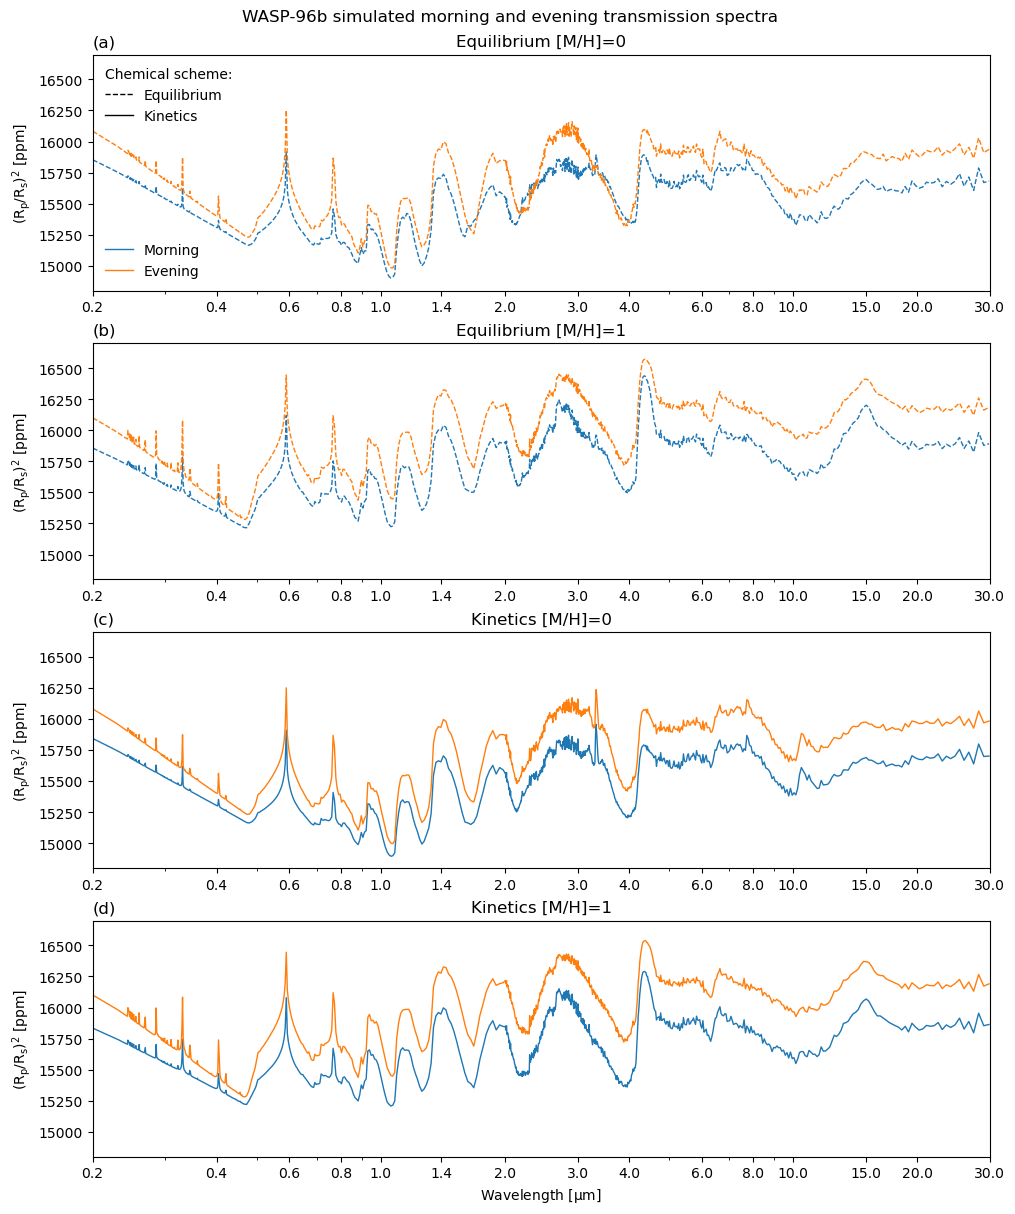

In [12]:
plt_transpec_summary_mor_eve(absrbrs, "02_30")